<h6><a href=\"javascript:toggle()\" target=\"_self\">Toggle source code</a></h6>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from scipy.spatial.distance import pdist
from scipy import stats

In [3]:
# Genes presence/absence matrix
# Made with Roary
roary = pd.read_table('../gene_presence_absence.csv',
                     sep=',',
                     low_memory=False)
# Set index (group name)
roary.set_index('Gene', inplace=True)
# Drop the other info columns
roary.drop(list(roary.columns[:10]), axis=1, inplace=True)

In [4]:
# Transform it in a presence/absence matrix (1/0)
roary.replace('.{2,100}', 1, regex=True, inplace=True)
roary.replace(np.nan, 0, regex=True, inplace=True)

In [5]:
# Read SNPs table
snps = pd.read_table('../SNPs_matrix.tsv')
snps.set_index(['position', 'alt'], inplace=True)

In [6]:
a = pd.read_table('../emap.matrix.txt')
a.set_index(['Gene'], inplace=True)

# Remove those strains that are always nan
remove = {i for i in a.index if list(np.isnan(a.ix[i])).count(True) == len(a.columns)}
a = a.drop(remove)
# Same for conditions
remove = {i for i in a.T.index if list(np.isnan(a.T.ix[i])).count(True) == len(a.T.columns)}
a = a.drop(remove)

In [7]:
# "Polish" the index
a.index = [a.index[i].split()[0] for i in range(len(a.index))]

In [8]:
# Zero the missing values (maybe better to impute them?)
a[np.isnan(a)] = 0

In [9]:
# Load the FDR corrections to identify proper phenotypes
f = pd.read_table('../emap.fdr.txt')
f.set_index('Gene', inplace=True)
# "Polish" the index
f.index = [f.index[i].split()[0] for i in range(len(f.index))]
v = a[f < 0.05]

In [10]:
wt = 'NT12001'

In [11]:
other = 'NT12017'

In [12]:
phen_dist = {}
for other in v.index:
    if other == wt:
        continue
    d = v.loc[[wt, other]]
    d[np.isnan(d)] = 0
    d[d > 0] = 1
    d[d < 0] = -1
#     d = d.T
#     phen_dist[other] = d[d[wt] > d[other]].shape[0]
    phen_dist[other] = pdist(d.as_matrix(), 'hamming')

In [13]:
snps_dist = {}
for other in snps.columns:
    if other == wt:
        continue
    d = snps[other].as_matrix()
    dwt = np.zeros(d.shape)
    snps_dist[other] = pdist(np.array([dwt, d]), 'hamming')

In [14]:
# snps_dist = {strain:x for strain, x in zip(snps.sum().index, snps.sum())}

In [15]:
# Get the accessory genome distance
wt = 'genome'
acc_dist = {}
for other in roary.columns:
    if other == wt:
        continue
    d = roary[[wt, other]]
#     acc_dist[other] = d[d[wt] != d[other]].shape[0]
    acc_dist[other] = pdist(d.T.as_matrix(), 'hamming')

In [16]:
pstrains = set(a.index)
gstrains = set(roary.columns)
vstrains = set(snps.columns)

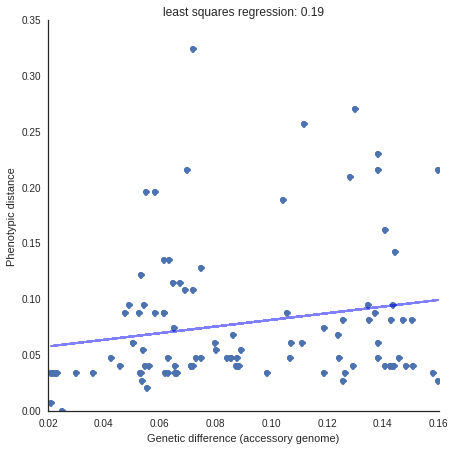

In [17]:
plt.figure(figsize=(7, 7))

acc_values = []
for strain, x in acc_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        acc_values.append((x, phen_dist[strain1]))

plt.plot([x[0] for x in acc_values],
         [x[1] for x in acc_values],
         'o')

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0][0] for x in acc_values],
                                                               [x[1][0] for x in acc_values])
line = slope*np.array([x[0] for x in acc_values])+intercept
plt.plot([x[0] for x in acc_values],line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (accessory genome)')
plt.ylabel('Phenotypic distance')

sns.despine()

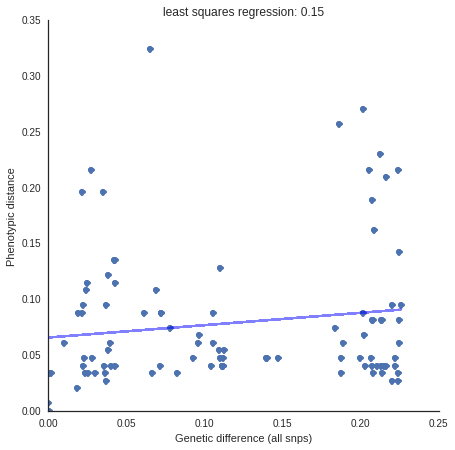

In [18]:
plt.figure(figsize=(7, 7))

snps_values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        snps_values.append((x, phen_dist[strain1]))

plt.plot([x[0] for x in snps_values],
         [x[1] for x in snps_values],
         'o')

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0][0] for x in snps_values],
                                                               [x[1][0] for x in snps_values])
line = slope*np.array([x[0] for x in snps_values])+intercept
plt.plot([x[0] for x in snps_values],line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (all snps)')
plt.ylabel('Phenotypic distance')

sns.despine()

In [19]:
max_acc = float(max([x[0] for x in acc_values]))
max_snps = float(max([x[0] for x in snps_values]))

In [20]:
values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        values.append((x, acc_dist[strain], phen_dist[strain1]))

In [21]:
clf = linear_model.LinearRegression()
clf.fit(np.array([[x[0][0], x[1][0]] for x in values]),
        np.array([x[2] for x in values]))
pass

In [22]:
d = {'phenotype':[x[2][0] for x in values],
     'genotype':[(x[0]*clf.coef_[0][0] + x[1]*clf.coef_[0][1])[0] for x in values]}
d = pd.DataFrame(d)

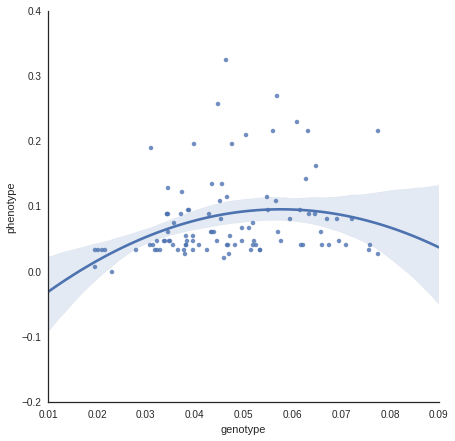

In [23]:
plt.figure(figsize=(7, 7))
sns.regplot('genotype', 'phenotype', d,
           order=2)
sns.despine()

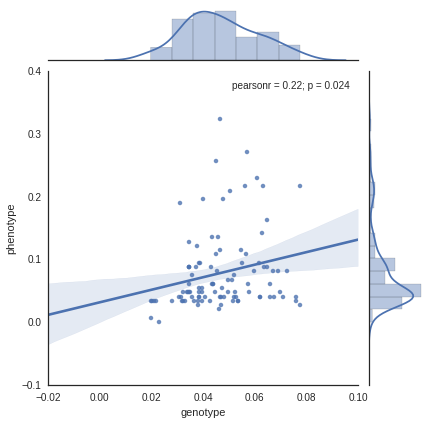

In [24]:
plt.figure(figsize=(7, 7))
sns.jointplot('genotype', 'phenotype', d, kind='reg')
pass

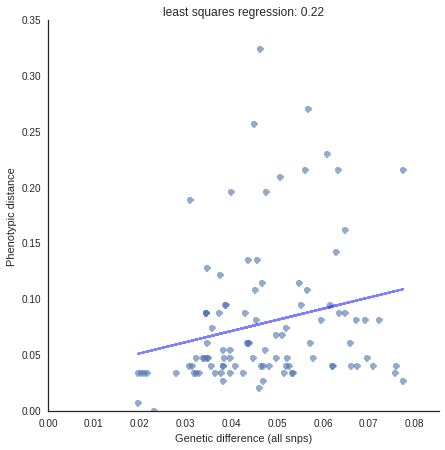

In [25]:
plt.figure(figsize=(7, 7))

vx = [x[0]*clf.coef_[0][0] + x[1]*clf.coef_[0][1] for x in values]
plt.plot(vx,
         [x[2] for x in values],
         'o',
         alpha=0.6)

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0] for x in vx],
                                                [x[2][0] for x in values])
line = slope*np.array(vx)+intercept
plt.plot(vx,line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (all snps)')
plt.ylabel('Phenotypic distance')

plt.xlim(0, max(vx)+max(vx)*0.1)

sns.despine()

In [26]:
# Read deleterious SNPs table
snps = pd.read_table('../SNPs_del_matrix.tsv')
snps.set_index(['position', 'alt'], inplace=True)

In [27]:
snps_dist = {}
for other in snps.columns:
    d = snps[other].as_matrix()
    dwt = np.zeros(d.shape)
    snps_dist[other] = pdist(np.array([dwt, d]), 'hamming')[0]

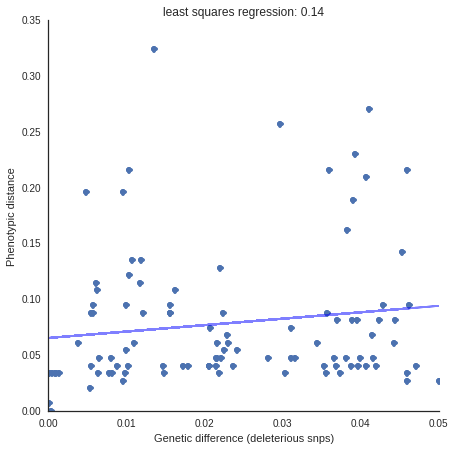

In [28]:
plt.figure(figsize=(7, 7))

snps_values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        snps_values.append((x, phen_dist[strain1]))

plt.plot([x[0] for x in snps_values],
         [x[1] for x in snps_values],
         'o')

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0] for x in snps_values],
                                                               [x[1][0] for x in snps_values])
line = slope*np.array([x[0] for x in snps_values])+intercept
plt.plot([x[0] for x in snps_values],line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (deleterious snps)')
plt.ylabel('Phenotypic distance')

sns.despine()

In [29]:
values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        if strain not in acc_dist:continue
        values.append((x, acc_dist[strain], phen_dist[strain1]))

In [30]:
clf = linear_model.LinearRegression()
clf.fit(np.array([[x[0], x[1][0]] for x in values]),
        np.array([x[2] for x in values]))
pass

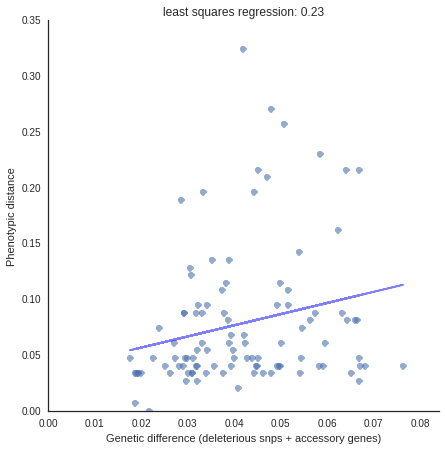

In [31]:
plt.figure(figsize=(7, 7))

vx = [x[0]*clf.coef_[0][0] + x[1]*clf.coef_[0][1] for x in values]
plt.plot(vx,
         [x[2] for x in values],
         'o',
         alpha=0.6)

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0] for x in vx],
                                                [x[2][0] for x in values])
line = slope*np.array(vx)+intercept
plt.plot(vx,line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (deleterious snps + accessory genes)')
plt.ylabel('Phenotypic distance')

plt.xlim(0, max(vx)+max(vx)*0.1)

sns.despine()

In [32]:
# Read deleterious SNPs table
snps = pd.read_table('../SNPs_functional_matrix.tsv')
snps.set_index(['position', 'alt'], inplace=True)

In [33]:
snps_dist = {}
for other in snps.columns:
    d = snps[other].as_matrix()
    dwt = np.zeros(d.shape)
    snps_dist[other] = pdist(np.array([dwt, d]), 'hamming')[0]

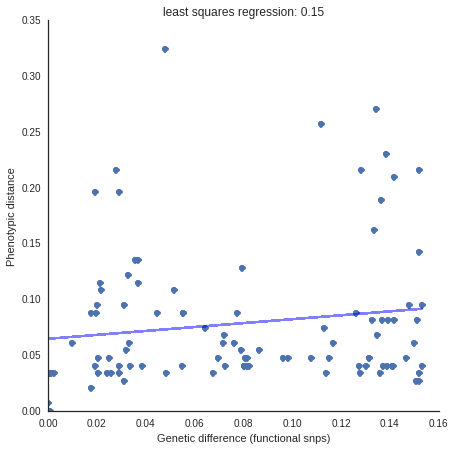

In [34]:
plt.figure(figsize=(7, 7))

snps_values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        snps_values.append((x, phen_dist[strain1]))

plt.plot([x[0] for x in snps_values],
         [x[1] for x in snps_values],
         'o')

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0] for x in snps_values],
                                                               [x[1][0] for x in snps_values])
line = slope*np.array([x[0] for x in snps_values])+intercept
plt.plot([x[0] for x in snps_values],line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (functional snps)')
plt.ylabel('Phenotypic distance')

sns.despine()

In [35]:
values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        if strain not in acc_dist:continue
        values.append((x, acc_dist[strain], phen_dist[strain1]))

In [36]:
clf = linear_model.LinearRegression()
clf.fit(np.array([[x[0], x[1][0]] for x in values]),
        np.array([x[2] for x in values]))
pass

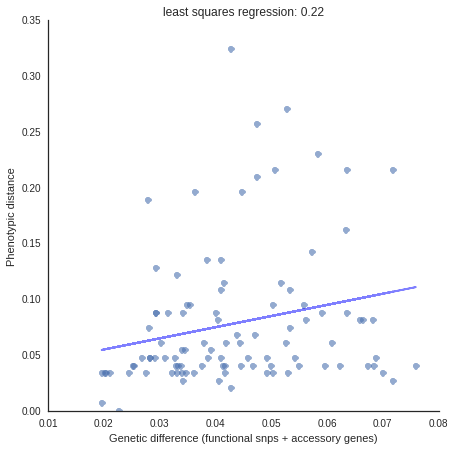

In [42]:
plt.figure(figsize=(7, 7))

vx = [x[0]*clf.coef_[0][0] + x[1]*clf.coef_[0][1] for x in values]
plt.plot(vx,
         [x[2] for x in values],
         'o',
         alpha=0.6)

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0] for x in vx],
                                                [x[2][0] for x in values])
line = slope*np.array(vx)+intercept
plt.plot(vx,line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (functional snps + accessory genes)')
plt.ylabel('Phenotypic distance')

#plt.xlim(0, max(vx)+max(vx)*0.1)

sns.despine()